In [1]:
import numpy as np
import pandas as pd
from obspy import read
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

In [2]:
def wavelet_transform(signal, wavelet='db4', level=6):  # Use a higher decomposition level
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    for coeff in coeffs:
        # Capture more statistics from each wavelet decomposition level
        features.append(np.mean(coeff))
        features.append(np.std(coeff))
        features.append(np.max(coeff))
        features.append(np.min(coeff))
    return features


In [3]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

data_directory = './data/lunar/training/data/S12_GradeA/'

In [7]:
X_all = []
arrival_times = []

# Extract features and target
for index, row in cat.iterrows():
    test_filename = row['filename']
    mseed_file = f'{data_directory}{test_filename}.mseed'
    
    if os.path.exists(mseed_file):
        stream = read(mseed_file)
        if len(stream) == 0:
            print(f"Warning: No data found in {mseed_file}")
            continue
        signal_values = stream[0].data
        wavelet_features = wavelet_transform(signal_values)
        X_all.append(wavelet_features)
    else:
        print(f"Warning: No data found for file {test_filename}")
        continue

    arrival_times.append(row['time_rel(sec)'])

# Convert lists to numpy arrays
X_all = np.array(X_all)
arrival_times = np.array(arrival_times)

# Handle NaNs and Infs in the data (if needed)
X_all = np.nan_to_num(X_all, nan=0.0, posinf=0.0, neginf=0.0)
arrival_times = np.nan_to_num(arrival_times, nan=0.0, posinf=0.0, neginf=0.0)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# Train-Test Split (split before duplicating)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, arrival_times, test_size=0.03, random_state=42)

# Now, duplicate only the training data 100 times
X_train = np.tile(X_train, (100, 1))  # Duplicate training features
y_train = np.tile(y_train, 100)       # Duplicate training targets

Epoch 1/132


c:\Users\munis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\munis\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1922320000.0000 - val_loss: 3574205696.0000
Epoch 2/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 413679520.0000 - val_loss: 563934208.0000
Epoch 3/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 332293760.0000 - val_loss: 226256208.0000
Epoch 4/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 289393408.0000 - val_loss: 279599712.0000
Epoch 5/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 257389568.0000 - val_loss: 118338776.0000
Epoch 6/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 252813344.0000 - val_loss: 408646112.0000
Epoch 7/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 218930768.0000 - val_loss: 289422880.0000
Epoch 8/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 227388528.0000 - val_loss: 172080528.0000
Epoch 9/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 194143744.0000 - val_loss: 200875216.0000
Epoch 10/132
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 207983024.0000 - val_

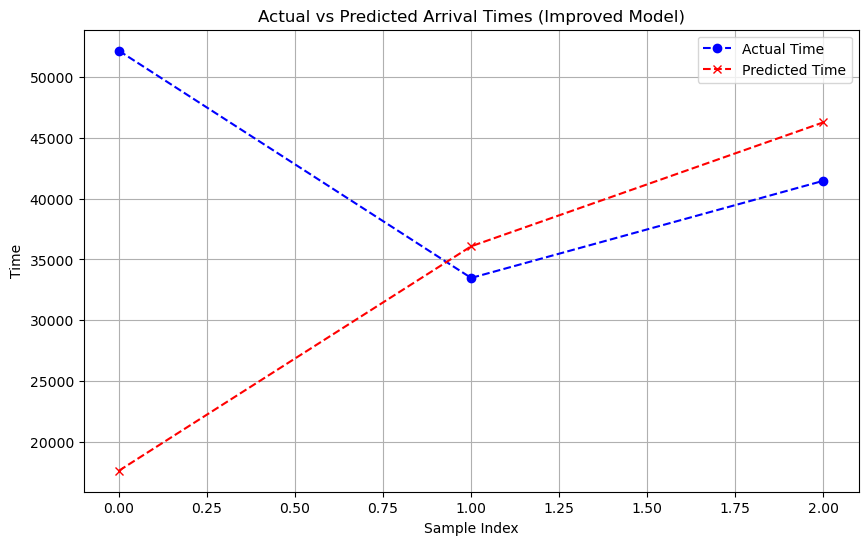

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the model architecture
model = Sequential()

# First hidden layer with 512 units, BatchNormalization, LeakyReLU, and Dropout
model.add(Dense(units=512, input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))  # Regularization with higher dropout rate

# Second hidden layer with 256 units
model.add(Dense(units=256))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

# Third hidden layer with 128 units
model.add(Dense(units=128))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

# Fourth hidden layer with 64 units
model.add(Dense(units=64))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

# Output layer for regression (no activation function)
model.add(Dense(units=1))

# Compile the model with a much lower learning rate
model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Train the model (no early stopping)
history = model.fit(X_train, y_train, epochs=132, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = model.predict(X_test)


In [9]:
# Folder paths and catalog generation for test data
test_folders = ['S16_GradeB', 'S16_GradeA', 'S15_GradeB', 'S15_GradeA', 'S12_GradeB']
test_data_directory = './data/lunar/test/data/'

# Loop through each folder and create catalogs
for folder in test_folders:
    folder_path = os.path.join(test_data_directory, folder)
    catalog_entries = []

    # Loop over files in each test folder
    for file in os.listdir(folder_path):
        if file.endswith('.mseed'):
            file_path = os.path.join(folder_path, file)
            stream = read(file_path)
            
            if len(stream) == 0:
                print(f"Warning: No data found in {file_path}")
                continue
            signal_values = stream[0].data
            
            # Extract wavelet features
            wavelet_features = wavelet_transform(signal_values)
            
            # Scale the wavelet features
            wavelet_features_scaled = scaler.transform([wavelet_features])
            
            # Predict using the model
            prediction = model.predict(wavelet_features_scaled)
            
            # Create an entry with filename and predicted time
            catalog_entry = {
                'filename': file,
                'predicted_time': round(prediction[0][0], 2) # Extracting the predicted time value
            }
            catalog_entries.append(catalog_entry)
            print(f"Prediction for {file} in folder {folder}: {prediction[0][0]}")

    # Convert catalog entries into a DataFrame for the current folder
    catalog_df = pd.DataFrame(catalog_entries)

    # Save the catalog DataFrame as a CSV file named after the folder
    catalog_filename = f'{folder}_catalog.csv'
    catalog_df.to_csv(catalog_filename, index=False)
    print(f"Catalog file '{catalog_filename}' has been created for folder {folder}.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Prediction for xa.s16.00.mhz.1973-08-25HR00_evid00443.mseed in folder S16_GradeB: -1070.382080078125
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction for xa.s16.00.mhz.1973-12-18HR00_evid00487.mseed in folder S16_GradeB: 38367.4296875
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction for xa.s16.00.mhz.1974-11-14HR00_evid00587.mseed in folder S16_GradeB: 70218.125
Catalog file 'S16_GradeB_catalog.csv' has been created for folder S16_GradeB.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction for xa.s16.00.mhz.1972-09-10HR00_evid00075.mseed in folder S16_GradeA: 11168.2353515625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction for xa.s16.00.mhz.1972-11-06HR00_evid00079.mseed in folder S16_GradeA: 65217.2890625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction for xa.s16.00.mhz.1972-11-08HR00_evid00080.mseed in folder S16_GradeA: 65284.5859375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction for xa.s16.00.mhz.1972-11-14HR00_evid00081.mseed in folder S16_G